In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
print("PyTorch Version: ",torch.__version__)

PyTorch Version:  1.0.0


首先我们定义一个基于ConvNet的简单神经网络

In [83]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

NLL loss的定义

$\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
        l_n = - w_{y_n} x_{n,y_n}, \quad
        w_{c} = \text{weight}[c] \cdot \mathbb{1}\{c \not= \text{ignore_index}\}$

In [84]:
def train(model, device, train_loader, optimizer, epoch, log_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset), 
                100. * batch_idx / len(train_loader), loss.item()
            ))

In [85]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [86]:
torch.manual_seed(53113)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = test_batch_size = 32
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)


lr = 0.01
momentum = 0.5
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

epochs = 2
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

save_model = True
if (save_model):
    torch.save(model.state_dict(),"mnist_cnn.pt")

Train Epoch: 1 [0/60000 (0.000000%)]	Loss: 2.297938
Train Epoch: 1 [3200/60000 (5.333333%)]	Loss: 0.569112
Train Epoch: 1 [6400/60000 (10.666667%)]	Loss: 0.205089
Train Epoch: 1 [9600/60000 (16.000000%)]	Loss: 0.094561
Train Epoch: 1 [12800/60000 (21.333333%)]	Loss: 0.180998
Train Epoch: 1 [16000/60000 (26.666667%)]	Loss: 0.041695
Train Epoch: 1 [19200/60000 (32.000000%)]	Loss: 0.134759
Train Epoch: 1 [22400/60000 (37.333333%)]	Loss: 0.052767
Train Epoch: 1 [25600/60000 (42.666667%)]	Loss: 0.113304
Train Epoch: 1 [28800/60000 (48.000000%)]	Loss: 0.060032
Train Epoch: 1 [32000/60000 (53.333333%)]	Loss: 0.087058
Train Epoch: 1 [35200/60000 (58.666667%)]	Loss: 0.193398
Train Epoch: 1 [38400/60000 (64.000000%)]	Loss: 0.091593
Train Epoch: 1 [41600/60000 (69.333333%)]	Loss: 0.078695
Train Epoch: 1 [44800/60000 (74.666667%)]	Loss: 0.040238
Train Epoch: 1 [48000/60000 (80.000000%)]	Loss: 0.038178
Train Epoch: 1 [51200/60000 (85.333333%)]	Loss: 0.052310
Train Epoch: 1 [54400/60000 (90.666667%)

In [94]:
# data = datasets.FashionMNIST('./fashion_mnist_data', train=True, transform=transforms.Compose([
#                        transforms.ToTensor(),
#                    ]))
data = datasets.MNIST('./mnist_data', train=True , transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt
# plt.imshow(data[0][0]), data[0][1]

In [99]:
data = [d[0].cpu().data.numpy() for d in data]

In [100]:
import numpy as np
print(np.mean(data))
print(np.std(data))

0.13066062
0.30810776


In [ ]:
torch.manual_seed(53113)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = test_batch_size = 32
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./fashion_mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.2860,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./fashion_mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3530,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)


lr = 0.01
momentum = 0.5
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

epochs = 2
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

save_model = True
if (save_model):
    torch.save(model.state_dict(),"fashion_mnist_cnn.pt")

# CNN模型的迁移学习

- 很多时候当我们需要训练一个新的图像分类任务，我们不会完全从一个随机的模型开始训练，而是利用_预训练_的模型来加速训练的过程。我们经常使用在`ImageNet`上的预训练模型。
- 这是一种transfer learning的方法。我们常用以下两种方法做迁移学习。
    - fine tuning: 从一个预训练模型开始，我们改变一些模型的架构，然后继续训练整个模型的参数。
    - feature extraction: 我们不再改变与训练模型的参数，而是只更新我们改变过的部分模型参数。我们之所以叫它feature extraction是因为我们把预训练的CNN模型当做一个特征提取模型，利用提取出来的特征做来完成我们的训练任务。
    
以下是构建和训练迁移学习模型的基本步骤：
- 初始化预训练模型
- 把最后一层的输出层改变成我们想要分的类别总数
- 定义一个optimizer来更新参数
- 模型训练

In [102]:
import numpy as np
import torchvision
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import time
import os
import copy
print("Torchvision Version: ",torchvision.__version__)

Torchvision Version:  0.2.0


数据
------

我们会使用*hymenoptera_data*数据集，[下载](https://download.pytorch.org/tutorial/hymenoptera_data.zip).

这个数据集包括两类图片, **bees** 和 **ants**, 这些数据都被处理成了可以使用`ImageFolder <https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder>`来读取的格式。我们只需要把``data_dir``设置成数据的根目录，然后把``model_name``设置成我们想要使用的与训练模型：
::
   [resnet, alexnet, vgg, squeezenet, densenet, inception]

其他的参数有：
- ``num_classes``表示数据集分类的类别数
- ``batch_size``
- ``num_epochs``
- ``feature_extract``表示我们训练的时候使用fine tuning还是feature extraction方法。如果``feature_extract = False``，整个模型都会被同时更新。如果``feature_extract = True``，只有模型的最后一层被更新。

In [103]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "./hymenoptera_data"
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"
# Number of classes in the dataset
num_classes = 2
# Batch size for training (change depending on how much memory you have)
batch_size = 32
# Number of epochs to train for 
num_epochs = 15
# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

In [104]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print("-"*10)
        
        for phase in ["train", "val"]:
            running_loss = 0.
            running_corrects = 0.
            if phase == "train":
                model.train()
            else: 
                model.eval()
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                with torch.autograd.set_grad_enabled(phase=="train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                _, preds = torch.max(outputs, 1)
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds.view(-1) == labels.view(-1)).item()
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
       
            print("{} Loss: {} Acc: {}".format(phase, epoch_loss, epoch_acc))
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "val":
                val_acc_history.append(epoch_acc)
            
        print()
    
    time_elapsed = time.time() - since
    print("Training compete in {}m {}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val Acc: {}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
# it = iter(dataloaders_dict["train"])
# inputs, labels = next(it)
# for inputs, labels in dataloaders_dict["train"]:
#     print(labels.size())

In [105]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [106]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    if model_name == "resnet":
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    return model_ft, input_size
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

读入数据
---------

现在我们知道了模型输入的size，我们就可以把数据预处理成相应的格式。


In [110]:
all_imgs = datasets.ImageFolder(os.path.join(data_dir, "train"), transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]))
loader = torch.utils.data.DataLoader(all_imgs, batch_size=batch_size, shuffle=True, num_workers=4)

In [111]:
img = next(iter(loader))[0]

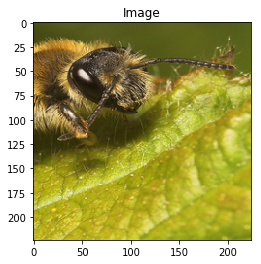

In [112]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(img[31], title='Image')


In [113]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [114]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
# print("Params to learn:")
# if feature_extract:
#     params_to_update = []
#     for name,param in model_ft.named_parameters():
#         if param.requires_grad == True:
#             params_to_update.append(param)
#             print("\t",name)
# else:
#     for name,param in model_ft.named_parameters():
#         if param.requires_grad == True:
#             print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [115]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, ohist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 0.7904135145124842 Acc: 0.48770491803278687
val Loss: 0.619462805246216 Acc: 0.6535947712418301

Epoch 1/14
----------
train Loss: 0.5450664719597238 Acc: 0.7459016393442623
val Loss: 0.4483603229320127 Acc: 0.8366013071895425

Epoch 2/14
----------
train Loss: 0.4105349744929642 Acc: 0.8360655737704918
val Loss: 0.3431931993151023 Acc: 0.8823529411764706

Epoch 3/14
----------
train Loss: 0.35894692970103903 Acc: 0.8524590163934426
val Loss: 0.27989230796792147 Acc: 0.9281045751633987

Epoch 4/14
----------
train Loss: 0.2908673418349907 Acc: 0.9098360655737705
val Loss: 0.2505438331685035 Acc: 0.9281045751633987

Epoch 5/14
----------
train Loss: 0.23799693706582803 Acc: 0.9385245901639344
val Loss: 0.2375101328285691 Acc: 0.934640522875817

Epoch 6/14
----------
train Loss: 0.24587850956643215 Acc: 0.9221311475409836
val Loss: 0.22650606248503416 Acc: 0.9215686274509803

Epoch 7/14
----------
train Loss: 0.2160148762288641 Acc: 0.8975409836065574
va

In [116]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs)


Epoch 0/14
----------
train Loss: 0.8567085520165866 Acc: 0.45491803278688525
val Loss: 0.724404592529621 Acc: 0.45751633986928103

Epoch 1/14
----------
train Loss: 0.7380818245840854 Acc: 0.5450819672131147
val Loss: 0.6716624471097211 Acc: 0.5816993464052288

Epoch 2/14
----------
train Loss: 0.6618092402082975 Acc: 0.6065573770491803
val Loss: 0.6962229531574873 Acc: 0.5359477124183006

Epoch 3/14
----------
train Loss: 0.620001350269943 Acc: 0.6639344262295082
val Loss: 0.6383026452625499 Acc: 0.6274509803921569

Epoch 4/14
----------
train Loss: 0.6266694020052426 Acc: 0.6639344262295082
val Loss: 0.6600921898106344 Acc: 0.6601307189542484

Epoch 5/14
----------
train Loss: 0.5753705130248773 Acc: 0.7254098360655737
val Loss: 0.627010538297541 Acc: 0.6339869281045751

Epoch 6/14
----------
train Loss: 0.607677086454923 Acc: 0.6434426229508197
val Loss: 0.634071911861694 Acc: 0.6405228758169934

Epoch 7/14
----------
train Loss: 0.5633049040544228 Acc: 0.7213114754098361
val Loss:

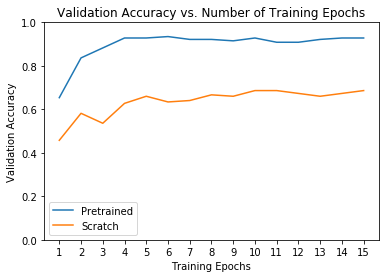

In [117]:

# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
# ohist = []
# shist = []

# ohist = [h.cpu().numpy() for h in ohist]
# shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),scratch_hist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()